In [2]:
import qmcpy as qp
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv, solve

In [2]:
plt.rcParams.update({'font.size': 14})

In [3]:
# def g(x,gamma):
#     g = np.prod(1 + (2 * np.pi**2)* gamma * (x * (x-1)+1/6), axis = 1)
#     return g

def p_alpha(x, gamma):
    g = np.prod(1 + (2 * np.pi**2)* gamma * (x * (x-1)+1/6), axis = 1)
    return np.mean(g)-1

def p_alpha_n(lattice,m_max,gamma):
    x = lattice.gen_samples(2**m_max)
    p_alpha_vec = np.zeros(1)
    for ii in range(m_max):
        p_alpha_vec = np.append(p_alpha_vec, p_alpha_vec + (2**ii) * p_alpha(x[:2**ii],gamma))
    p_alpha_vec = np.append(p_alpha_vec,(2**m_max) * p_alpha(x,gamma))
    p_alpha_vec = p_alpha_vec[1:]/np.arange(1,2**m_max+1)
    return p_alpha_vec


In [4]:
d = 2
sampler = qp.Lattice(d,randomize=False)
gamma = np.array([0.1, 0.05])
m_max = 10
print(p_alpha(sampler.gen_samples(4),gamma))
#print(p_alpha_n(sampler,m_max,gamma))

p_alpha_values = p_alpha_n(sampler,m_max,gamma)

0.04817659679330921


/Users/laramatiukha/Documents/GitHub/QMCSoftware/qmcpy/discrete_distribution/lattice/lattice.py:250


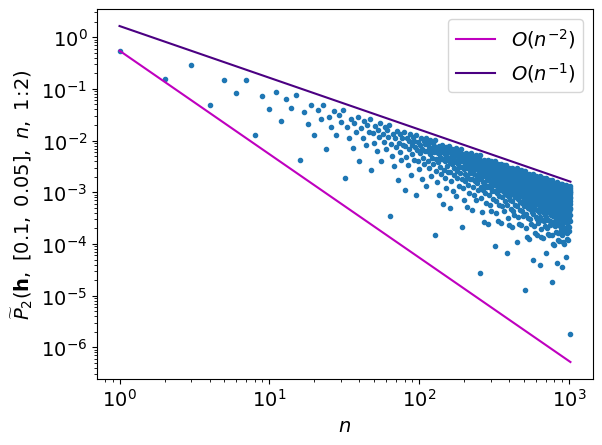

In [7]:

n_range = np.arange(1, 2**m_max+1)
plt.loglog(n_range, p_alpha_values, '.')


line = p_alpha_values[0] / n_range**2  
plt.loglog(n_range, line, 'm', label=r'$O(n^{-2})$') 

line1 = 3 * p_alpha_values[0] / n_range
plt.loglog(n_range, line1, 'indigo', label=r'$O(n^{-1})$') 

plt.xlabel('$n$')
plt.ylabel(r'$\widetilde{P}_2(\mathbf{h},\ [0.1,\ 0.05],\ n,\ 1\!:\!2)$')
plt.legend()
plt.show()



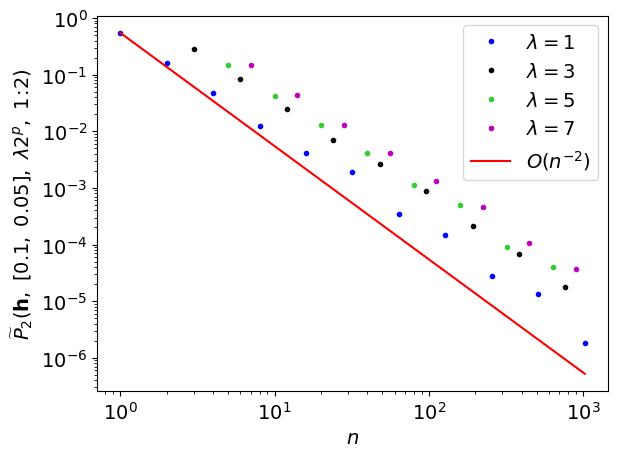

In [8]:
lambdas = [1, 3, 5, 7]
colors = ['b','k', 'limegreen', 'm'] 
for l, color in zip(lambdas, colors):
    vals_n = []
    p = 0
    while (n := l * (2**p)) <= 2**m_max:
        vals_n.append(n)
        p += 1
    vals_n = np.array(vals_n)
    plt.loglog(vals_n, p_alpha_values[vals_n - 1], '.', color=color, label=fr'$\lambda={l}$')


line = p_alpha_values[0] / n_range**2  
plt.loglog(n_range, line, 'r', label=r'$O(n^{-2})$') 

plt.xlabel('$n$')
plt.ylabel(r'$\widetilde{P}_2(\mathbf{h},\ [0.1,\ 0.05],\ \lambda 2^p,\ 1\!:\!2)$')
plt.legend()
plt.tight_layout()
plt.show()

In [108]:
def GramMat(x=None, coordwts=None):
    if x is None:
        x = np.array([[0, 0], [0.5, 0.5], [0.25, 0.25]])
    if coordwts is None:
        coordwts = (np.arange(1, 51, dtype=float))**-2  
    
    n, d = x.shape
    coordwts = coordwts[:d]  
    
    xmat = np.mod(x[:, np.newaxis, :] - x[np.newaxis, :, :], 1)
    K = np.prod(1 + 0.5 * coordwts[np.newaxis, np.newaxis, :] * (xmat * (xmat - 1) + 1/6), axis=2)
    
    return K


K = GramMat()
print(K)


[[1.10590278 0.94835069 0.98700629]
 [0.94835069 1.10590278 0.98700629]
 [0.98700629 0.98700629 1.10590278]]


In [109]:
def discrepancy(n=2**8, d=2, coordwts=(np.arange(1, 51, dtype=float)) ** -2):
    
    optfwtsall = np.zeros((n, n))
    ssdiscopt = np.zeros(n)
    ssdisc = np.zeros(n)
    
    xlat = qp.Lattice(d).gen_samples(n)
    kernellat = GramMat(xlat, coordwts)
    
    for m in range(1, n + 1):
        K = kernellat[:m, :m]
         
        preoptfwts = inv(K) @ np.ones((m, 1))

        optfwts = preoptfwts / (np.ones((1, m)) @ preoptfwts)
        optfwtsall[:m, m - 1] = optfwts.flatten()
        
        ssdiscopt[m - 1] = 1 - 2 * np.sum(optfwts) + optfwts.T @ K @ optfwts
        ssdisc[m - 1] = -1 + np.ones((1, m)) @ K @ np.ones((m, 1)) / m**2
    
    return ssdiscopt, ssdisc, xlat, optfwtsall

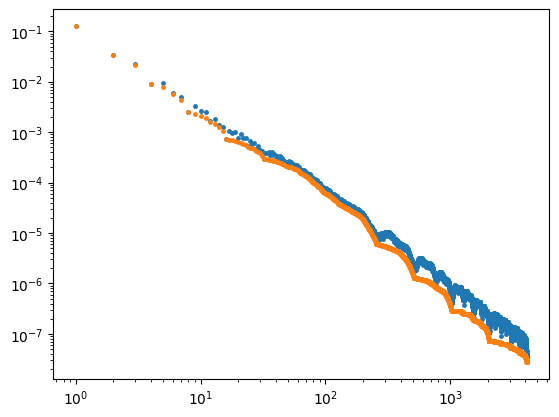

In [9]:
n = 2**12
d = 6

coordwts = (np.arange(1, 51, dtype=float)) ** -2
ssdiscopt, ssdisc, xlat, optfwts = discrepancy(n,d,coordwts)


In [10]:
import pickle

disc_data = {
    'ssdiscopt': ssdiscopt,
    'ssdisc': ssdisc,
    'xlat': xlat,
    'optfwts': optfwts
}

with open('discrepancy_data.pkl', 'wb') as f:
    pickle.dump(disc_data , f)

In [97]:
with open('discrepancy_data.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

ssdiscopt = loaded_data['ssdiscopt']
ssdisc = loaded_data['ssdisc']
xlat = loaded_data['xlat']
optfwts = loaded_data['optfwts']

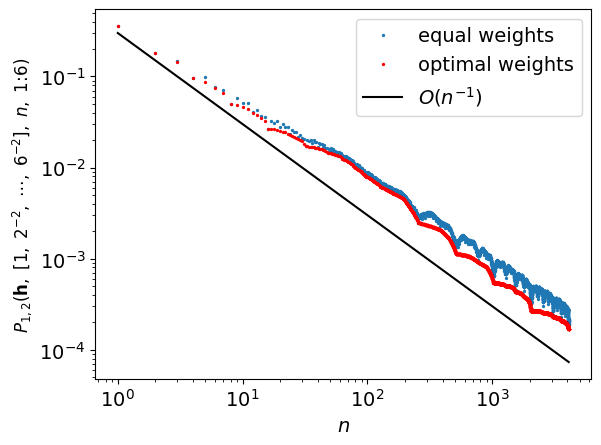

In [196]:
plt.figure()
plt.loglog(np.arange(1, n + 1), np.sqrt(ssdisc), '.', markersize=2.75, label = 'equal weights')
plt.loglog(np.arange(1, n + 1), np.sqrt(ssdiscopt), '.', markersize=2.75, color = 'r',label = 'optimal weights')

line = 0.3/np.arange(1, n + 1)
plt.loglog(np.arange(1, n + 1), line,label=r'$O(n^{-1})$',color='k')
plt.xlabel(r'$n$')
plt.ylabel(r'$P_{1,2}(\mathbf{h}, \ [1, \ 2^{-2}, \ \cdots, \ 6^{-2}], \ n, \ 1\!:\!6)$',fontsize=12)
plt.legend()
plt.show()

In [182]:
n = 2**7
d = 2
coordwts = (np.arange(1, 51, dtype=float)) ** -2
ssdiscopt_n, ssdisc_n, _, _ = discrepancy(n,d,coordwts)

n_vec = np.arange(1,n+1)
n_floor = (2**np.floor(np.log2(n_vec))).astype(int)

print(n_vec)
print(n_floor)


ratio_eq = ssdisc_n/ssdisc_n[n_floor-1]
ratio_uneq = ssdiscopt_n/ssdiscopt_n[n_floor-1]


[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128]
[  1   2   2   4   4   4   4   8   8   8   8   8   8   8   8  16  16  16
  16  16  16  16  16  16  16  16  16  16  16  16  16  32  32  32  32  32
  32  32  32  32  32  32  32  32  32  32  32  32  32  32  32  32  32  32
  32  32  32  32  32  32  32  32  32  64  64  64  64  64  64  64  64  64
  64  64  64  64  64  64  64  64  64  64  64  64  64  64  64  64  64  64
  64  64  64  64  64  64  64  64  64  64  64  64  64  64  64  64  64  64
  64  64  64  64  64  64  64  64  64  64 

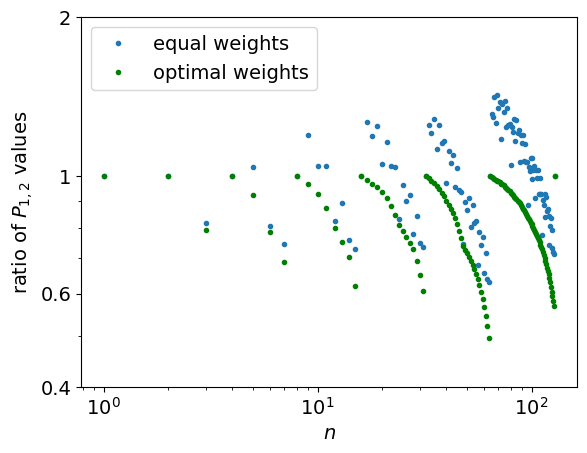

In [188]:
plt.loglog(n_vec, np.sqrt(ratio_eq), '.', linestyle='none',label='equal weights')
plt.loglog(n_vec, np.sqrt(ratio_uneq), '.', linestyle='none',color='g',label='optimal weights')
plt.xlabel('$n$')
plt.ylabel('ratio of $P_{1,2}$ values')

plt.ylim(0.4,2)
plt.yticks([0.4, 0.6, 1, 2], [0.4, 0.6, 1, 2])
plt.xticks()

plt.legend(loc='upper left')
plt.show()

In [189]:
n_ceil = (2**np.ceil(np.log2(n_vec))).astype(int)

print(n_vec)
print(n_ceil)

ratio_eq = ssdisc_n/ssdisc_n[n_ceil-1]
ratio_uneq = ssdiscopt_n/ssdiscopt_n[n_ceil-1]

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128]
[  1   2   4   4   8   8   8   8  16  16  16  16  16  16  16  16  32  32
  32  32  32  32  32  32  32  32  32  32  32  32  32  32  64  64  64  64
  64  64  64  64  64  64  64  64  64  64  64  64  64  64  64  64  64  64
  64  64  64  64  64  64  64  64  64  64 128 128 128 128 128 128 128 128
 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128
 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128
 128 128 128 128 128 128 128 128 128 128 

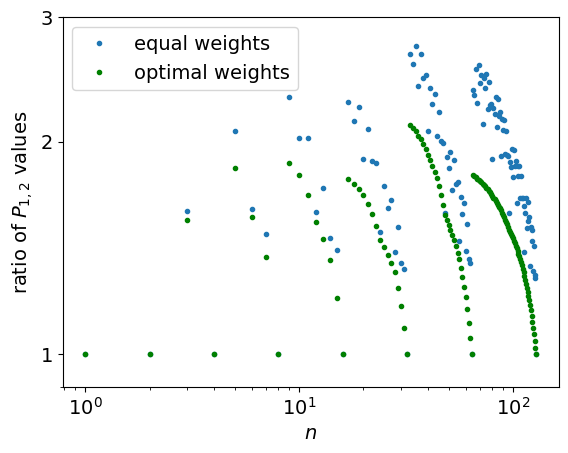

In [195]:
plt.loglog(n_vec, np.sqrt(ratio_eq), '.', linestyle='none', label='equal weights')
plt.loglog(n_vec, np.sqrt(ratio_uneq), '.', linestyle='none',color='g', label='optimal weights')

plt.ylabel('ratio of $P_{1,2}$ values')
plt.xlabel('$n$')
plt.ylim(0.9,3)
plt.yticks([1, 2, 3], [1, 2, 3])

plt.legend()
plt.show()